Notebook elaborado para apresentar uma breve introdução ao processamento de sinais.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
[emerson.almeida@ufu.br](mailto:emerson.almeida@ufu.br)<br>

<p>&nbsp;</p>
Última modificação: 11/02/2021

# Instruções iniciais

Neste notebook você irá avaliar as curvas de resistividade aparente de alguns modelos geoelétricos e irá elaborar modelos geoelétricos a partir de curvas de resistividade aparente obtidas em Sondagens Elétricas Verticais (SEVs) em arranjo Schlumberger. Para isto **leia atentamente** as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, **não é obrigatório que você conheça a programação** para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

 
# Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os pacotes, módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo executa a instalação do pacote open sourece [SimPEG](https://docs.simpeg.xyz/), responsável por executar os cálculos relacionados à física do problema. Se você está executando este notebook no MyBinder ou no Google Colab não se preocupe, nada será instalado na sua máquina local. Execute esta célula uma vez antes de executar qualquer outra parte do código e não altere nada no código apresentado na célula para não criar problemas na execução do código.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado. A execução desta primeira célula pode demorar um pouco, pois um pacote inteiro estará sendo instalado. Aguarde o término da instalação antes de executar a célula seguinte.

<p>&nbsp;</p>

**Importante!** Nem todas as células de código desta demostração irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [ ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

In [3]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_fwd_1_dcr_sounding.html#sphx-glr-content-tutorials-05-dcr-plot-fwd-1-dcr-sounding-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

Cloning into 'simpeg'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (478/478), done.
remote: Total 53034 (delta 561), reused 527 (delta 333), pack-reused 52212
Receiving objects: 100% (53034/53034), 79.03 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (38860/38860), done.
/content/simpeg
Obtaining file:///content/simpeg (from -r requirements.txt (line 1))
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 614kB 9.9MB/s 
     |████████████████████████████████| 153kB 30.3MB/s 
     |████████████████████████████████| 215kB 32.9MB/s 
  Created wheel for pymatsolver: filename=pymatsolver-0.1.2-cp36-none-any.whl size=15910 sha256=4f3248ba90df76f88fbdb9b59fe5ecf21fb145dbb8ba6ace5bb7983ea058bf88
  Stored in directory: /root/.cache/pip/wheels/09/66/a3/c540b8d29d1edab2bd4fabe368987aedc7fda18e742672be5b
  Created wheel for properties: filename=properties-0.6.1-cp36-none-any.wh

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_layer

tendcurva = False  # para uso com o exercício 2

class sev():

    """
    Sondagem Elétrica Vertical configurada de acordo com
    os parâmetros necessários para uso com o SimPEG
    """

    def __init__(self, meioAB, meioMN, arranjo):

        if len(meioAB)>len(meioMN):
            print("\nERRO: número de posições de AB/2 é maior do número de "
                "posições de MN/2.\n")
            return None
          
        elif len(meioAB)<len(meioMN):
            print("\nERRO: número de posições de AB/2 é menor do número de "
                "posições de MN/2.\n")
            return None

        else:
            self.arranjo = arranjo
            self.meioAB = meioAB      # distâncias de AB/2
            self.meioMN = meioMN      # distâncias de MN/2
            source_list = []

            for ii in range(len(meioAB)):
                A = np.r_[-1 * meioAB[ii], 0.0,0.0]
                B = np.r_[meioAB[ii], 0.0,0.0]
                M = np.r_[-1 * meioMN[ii], 0.0,0.0]
                N = np.r_[meioMN[ii], 0.0,0.0]

                receiver_list = [dc.receivers.Dipole(M, N)]
                source_list.append(dc.sources.Dipole(receiver_list, A, B))

            self.survey = dc.Survey(source_list)

            # inicializa sem nada porque ainda não foi feita a modelagem
            self.rho_a = None


    def fwd(self, modelo):

        """
        Executa a modelagem com os parâmetros definidos para a SEV
        """

        simulation = dc.simulation_1d.Simulation1DLayers(
                      survey = self.survey,
                      rhoMap = modelo.model_map,
                      thicknesses = modelo.h,
                      data_type = "apparent_resistivity"
                      )

        self.rho_a = simulation.dpred(modelo.rho)


class modelo_geo():
    """
    Modelo Geoelétrico 1-D a ser modelado
    """
    
    def __init__(self, rho, h):

        self.rho = rho
        self.h = h
        self.z_max = np.sum(self.h) * 1.3

        # Define mapping from model to 1D layers
        self.model_map = maps.IdentityMap(nP=len(self.rho))


    def mostra_grafico(self, n_fig='X'):
        """
        Método para plotar o modelo
        """
        
        # Define a malha 1D
        mesh = TensorMesh([np.r_[self.h, self.z_max - self.h.sum()]])

        fig, ax1 = plt.subplots(figsize=(4,4))
        plot_layer(self.model_map * self.rho, mesh, xlim=[10, 1e4], \
                   ax=ax1, showlayers=False)

        ax1.set_xlabel('Resistividade Real (Ohm.m)')
        ax1.set_ylabel('Profundidade (m)')
        ax1.set_title('Figura ' + n_fig + '. Modelo de n=' + \
                      str(len(self.rho)) + ' camadas')
        ax1.grid(which='both')
        plt.show()


class curva_campo():
    
    """
    Define o objeto referente à curva de campo, com as posições de eletrodos e 
    valores de resistividade aparente
    """
    
    def __init__(self, AB_campo, MN_campo, dados_medidos):
        self.AB = AB_campo
        self.MN = MN_campo
        self.rho_a = dados_medidos
        
    def plota_dados(self):
        
        fig, ax = plt.subplots(figsize=(8,8))
        ax.loglog(sondagem.meioAB, sondagem.rho_a, 'ok', linewidth='0.0')
        ax.set_xlabel('AB/2 (m)', fontsize='14')
        ax.set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
        ax.set_title('Dados de campo', fontsize='14')
        ax.set_ylim([10, 1000])
        ax.set_xlim([1, 1000])
        ax.grid(which='both')

        plt.show()
        

def calcula_tendencias(sondagem, modelo):
    """
    Calcula a tendência da curva de resistividade aparente para cada
    camada individualmente, como se a camada correspondesse ao semi-espaço
    homogêneo de resistividade correspondente à resistividade da camada
    sendo considerada.
    
    Utiliza as configurações da sondagem fornecida para executar o cálculo
    do problema direto N-1 vezes, onde N é o número de camadas do modelo
    fornecido. A execução começa com um modelo de uma única camada, e as
    camadas são consideradas na modelagem gradativamente, uma a uma.
    """
    
    rho_a_list = []
    sev_parcial = deepcopy(sondagem)

    for ii in range(0, len(modelo.rho)-1):

        if ii==0:
            # Faz um modelo de duas camadas de resistividades iguais
            # para simular um semi-espaço homogêneo.
            res = np.r_[resistividades[:ii+1], resistividades[:ii+1]]
            esp = espessuras[:ii+1]

        else:
            # Cria modelos com aumento gradual do número de camadas 
            res = resistividades[:ii+1]
            esp = espessuras[:ii]

        modelo_parcial = modelo_geo(res, esp)
        sev_parcial.fwd(modelo_parcial)
        rho_a_list.append(sev_parcial.rho_a)

    return rho_a_list


def plota_sondagem(sondagem, modelo, tendencias=False, n_fig='X'):
    
    """
    Exibe a curva de resistividade aparente resultante da modelagem
    """
  
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    # insere as curvas com as tendências da resistividade aparente
    if tendencias:
        curvas = calcula_tendencias(sondagem, modelo)
        cor = ['--r', '--y', '--c', '--k', '--m', '-.r', '-.y', \
               '-.c', '-.k', '-.m']
        
        for n in range(len(curvas)):
            ax[0].loglog(sondagem.meioAB, curvas[n], cor[n], \
                         label='n = ' + str(n+1))
          
        ax[0].loglog(sondagem.meioAB, sondagem.rho_a, '-b', \
                     label='n = ' + str(n+2))
        ax[0].legend(loc='upper right')
    
    else:
        ax[0].loglog(sondagem.meioAB, sondagem.rho_a, '-b')
    
    ax[0].plot(sondagem.meioAB, sondagem.rho_a, 'ok')
    ax[0].set_xlabel('AB/2 (m)', fontsize='14')
    ax[0].set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
    ax[0].set_title('Figura ' + n_fig + 'a. Sondagem ' + sondagem.arranjo, \
                    fontsize='14')
    ax[0].set_ylim([10, 1000])
    ax[0].set_xlim([1, 1000])
    ax[0].grid(which='both')
    
    mesh = TensorMesh([np.r_[modelo.h, modelo.z_max - modelo.h.sum()]])
    plot_layer(modelo.model_map * modelo.rho, mesh, xlim=[10, 1e4], \
                ax=ax[1], showlayers=False)
    ax[1].set_xlabel('Resistividade Real (Ohm.m)')
    ax[1].set_ylabel('Profundidade (m)')
    ax[1].set_title('Figura ' + n_fig + 'b. Modelo de n=' + \
                    str(len(modelo.rho)) + ' camadas', fontsize='14')
    ax[1].grid(which='both')

    plt.show()


def compara_sevs(sev1, sev2, n_fig='X'):
    
    """
    Exibe uma figura para comparação entre duas sondagens diferentes
    """

    fig, ax1 = plt.subplots(figsize=(7, 7))
    
    ax1.loglog(sev1.meioAB, sev1.rho_a, '-ob', label=sev1.arranjo)
    ax1.loglog(sev2.meioAB, sev2.rho_a, '-or', label=sev2.arranjo)
    ax1.set_xlabel('AB/2 (m)', fontsize='14')
    ax1.set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
    ax1.set_title('Figura ' + n_fig + '. Comparação entre curvas de SEVs', \
                  fontsize='14')
    ax1.set_ylim([10, 1000])
    ax1.legend(loc='upper right')
    ax1.grid(which='both')
    plt.show()

# Passo 02 - Configuração do arranjo

Comece pela configuração da SEV, definindo as meias distancias entre os eletrodos A e B (corrente) e entre os eletrodos M e N (Potencial). Este notebook irá utilizar apenas o arranjo Schlumberger, pois é o de uso mais comum em campo. A abertura entre eletrodos de potencial que será utilizada aqui é um exemplo de espaçamentos que podem ser utilizados em campo (porém não é mandatório seguir exatamente estes espaçamentos.)

Execute a célula abaixo para configurar as posições dos eletrodos.

In [5]:
eletrodos_AB = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, \
                         15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, \
                         100.0, 150.0, 200.0])

eletrodos_MN = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, \
                         2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 10.0, 10.0, \
                         10.0, 10.0, 10.0])

# Passo 02 - Configuração dos modelos geoelétricos

A modelagem requer que seja fornecido um modelo geoelétrico, portanto vamos criá-lo aqui. Lembre-se de que o modelo geoelétrico apresenta os principais contrastes de resistividade, cujas profundidades das interfaces podem coincidir com as profundidades dos contatos geológicos ou não. Neste notebook você irá observar o comportamento da curva em alguns modelos em particular.

### Modelo 01

Este é um modelo simples, de três camadas. Você pode interpretá-lo como, por exemplo, uma camada argilosa sobre uma camada de basalto não fraturado:

|     Camada      |  Resistividade ($\Omega$.m) | Espessura (m) |    Geologia      |
|:---------------:|:---------------------------:|:-------------:|:----------------:|
| 1               | 100.0                        |      4.0      |    Camada argilosa          |
| 2               | 1500.0                       |      30.0      | Basalto   |
| 3               | 600.0                       |      -      | Basalto fraturado saturado  |

Execute a célula abaixo para configurar o modelo e visualizá-lo.

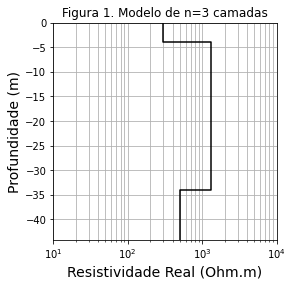

In [24]:
# modelo 1D de três camadas
resistividades = np.r_[300.0, 1300.0, 500.0]
espessuras = np.r_[4.0, 30.0]

meu_modelo_01 = modelo_geo(resistividades, espessuras)
meu_modelo_01.mostra_grafico(n_fig='1')

Execute a célula abaixo para executar a SEV com as posições de eletrodos e o modelo geoelétrico configurados acima.



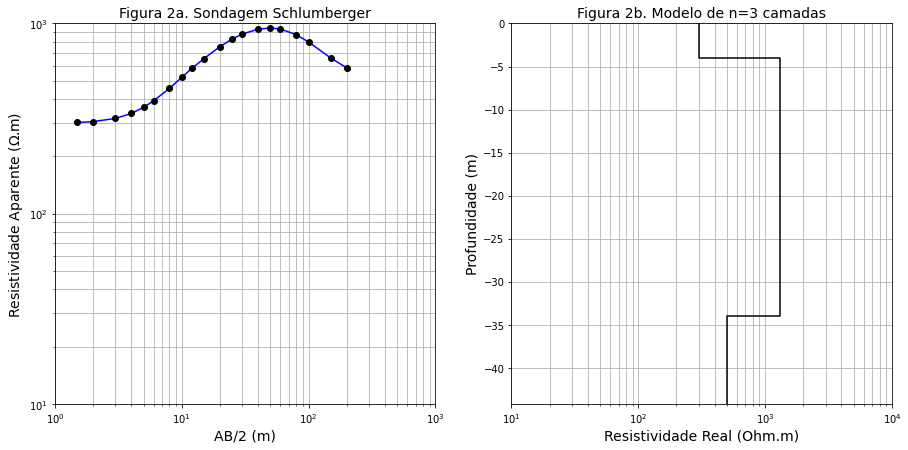

In [25]:
sev01 = sev(eletrodos_AB, eletrodos_MN, 'Schlumberger')
sev01.fwd(meu_modelo_01)
plota_sondagem(sev01, meu_modelo_01, tendencias=tendcurva, n_fig='2')

**Pergunta:** Quantas camadas você consegue identificar através das tendências da curva de resistividade aparente? É possível identificar todas as camadas do modelo?

### Modelo 02

Considere agora um modelo um pouco mais elaborado. Execute a célula abaixo para definir um modelo de 5 camadas que pode ser interpretado da seguinte forma:

|     Camada      |  Resistividade ($\Omega$.m) | Espessura (m) |    Geologia      |
|:---------------:|:---------------------------:|:-------------:|:----------------:|
| 1               | 100.0                        |      4.0      |    Aterro argiloso          |
| 2               | 500.0                       |      15.0      | Arenito seco     |
| 3               | 60.0                        |      2.0     | Arenito saturado |
| 4               | 1000.0                      |     15.0       | Granito são      |
| 5               | 100.0                      |     -       | Granito fraturado saturado      |

Execute a célula abaixo para configurar o modelo e apresentá-lo.

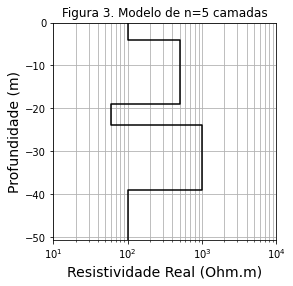

In [27]:
# modelo 1D
resistividades = np.r_[100.0, 500.0, 60.0, 1000, 100.0]
espessuras = np.r_[4.0, 15.0, 5.0, 15]

meu_modelo_02 = modelo_geo(resistividades, espessuras)
meu_modelo_02.mostra_grafico(n_fig='3')

e execute a célula abaixo para visualizar a curva de resistividade aparente correspondente.

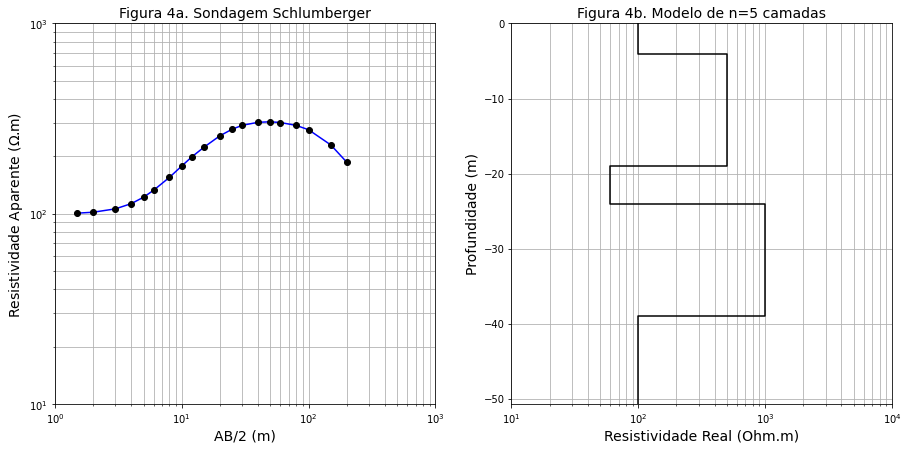

In [28]:
sev_02 = sev(eletrodos_AB, eletrodos_MN, 'Schlumberger')
sev_02.fwd(meu_modelo)
plota_sondagem(sev_02, meu_modelo, tendencias=tendcurva, n_fig='4')

**Perguntas:** Quantas camadas você identifica na sondagem apenas observando as tendências da curva de resistividade aparente? É possível identificar todas as camadas do modelo?




# Passo 04 - Modelagem da curva de campo

Agora você irá obter um modelo geoelétrico a partir de uma curva obtida em campo. Aqui você irá observar também a ocorrência da *embreagem*, que é um procedimento feito em uma sondagem com arranjo Schlumberger quando se pretende aumentar o espaçamento entre os eletrodos M e N.



In [30]:
AB_campo = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.0, 8.0, 8.0, 10.0, \
                     10.0, 12.0, 15.0, 15.0, 20.0, 20.0, 25.0, 30.0, 40.0, \
                     40.0, 50.0, 50.0, 60.0, 60.0, 80.0, 80.0, 100.0, 100.0, \
                     150.0, 150.0, 200.0, 200])
MN_campo = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, \
                     1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 5.0, \
                     2.0, 5.0, 5.0, 10.0, 5.0, 10.0, 5.0, 10.0, 5.0, 10.0, \
                     5.0, 10.0])
dados_medidos = np.array([2157.0, 2598.0, 3592.0, 3810.0, 3610.0, 3167.0, \
                          3215.0, 2728.0, 2771.0, 2286.0, 2320.0, 2004.0, \
                          1372.0, 1415.0, 703.0, 727.0, 457.0, 296.0, 202.0, \
                          233.0, 193.0, 217.0, 235.0, 229.0, 288.0, 280.0, \
                          348.0, 339.0, 501.0, 484.0, 637.0, 621.0])

minha_sondagem = curva_campo(AB_campo, MN_campo, dados_medidos)

minha_sondagem.plota_dados()

# Exercícios

**1-** Como você avalia a curva da Figura 3a em relação à curva mostrada na Figura 2a? Por que isso acontece?

**3-** Considere o modelo da tabela abaixo:

|     Camada      |  Resistividade ($\Omega$.m) | Espessura (m) |    Geologia      |
|:---------------:|:---------------------------:|:-------------:|:----------------:|
| 1               | 50.0                        |      0.5      |    Solo          |
| 2               | 300.0                       |      5.0      | Arenito seco     |
| 3               | 35.0                        |      80.0     | Arenito saturado |
| 4               | 1000.0                      |       -       | Granito são      |

**a)** Qual a abertura mínima de eletrodos de injeção de corrente para que se possa identificar de forma confiável a interface superior do granito são? Calcule uma estimativa, justificando-a adequadamente, e demonstre que sua resposta atinge a profundidade desejada fazendo uma modelagem. Considere o arranjo Schlumberger, modificando as aberturas entre os eletrodos A e B no Passo 03 e modificando as aberturas entre os eletrodos M e N no Passo 

**b)** Quantas camadas você observa na curva de resistividade aparente? Por quê?